<a href="https://colab.research.google.com/github/VillcaJaitaLFernando/Sis421-2-2025/blob/main/Reconocimiento_de_Actas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Construya un modelo que cumpla con lo siguiente:

El modelo debe permitir capturar los datos de las actas de conteo de votos correspondientes a la elección para presidente en el presente año.
Se debe lograr capturar la siguiente información: número de mesa, numero de votos por partido, blancos y nulos.
Los datos que se capturen deben ser almacenados en una base de datos, de acuerdo a una estructura que cada estudiante vea por conveniente.
Se deja a criterio del estudiante el procesamiento de las imágenes de las actas antes de aplicar un modelo preentrenado para reconocimiento de caracteres. Sin embargo se recomienda utilizar algunas marcas o guías propias de la papeleta escaneada para realizar el respectivo troceado de la imagen en fragmentos de imagen que represente los datos que se busca capturar.
Se debe subir a gitlab o github y copiar la dirección del repositorio además de subir los código en este medio.

La defensa del trabajo, se realizará el día viernes 29 de agosto a partir de hrs. 9:00 y se considerará lo siguiente:

Dominio de la solución aplicada.
Dominio de python y las librerías empleadas.
Dominio del modelo preentrenado utilizado.
Dominio de aspectos relacionados a deep learning.
Factores de optimización, regularización, buenas practicas.
Demostración suficiente de la efectividad del modelo desarrolla (pruebas de error, matriz de confusión, precisión, error entre otros)

In [5]:
# Librerías necesarias
!pip install opencv-python-headless pytesseract sqlalchemy tensorflow keras scikit-learn matplotlib

# Librerías básicas
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# OCR
!sudo apt install tesseract-ocr -y
!pip install pytesseract

import pytesseract

# Base de datos (SQLite para simplicidad)
import sqlite3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# Montar Google Drive (para acceder a dataset local subido)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Definir la ruta base de tu dataset
BASE_DIR = "/content/drive/MyDrive/Sis 421 Inteligencia Artificial 2/ACTAS VOTACIONES FACULTAD TECNOLOGIA"

In [ ]:
# Listar las imágenes
imagenes = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

print(f"Total de actas encontradas: {len(imagenes)}")

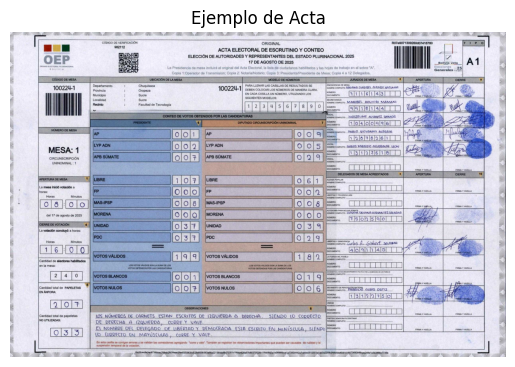

In [4]:
# Mostrar un ejemplo de imagen
ejemplo = cv2.imread(os.path.join(BASE_DIR, "acta 1.jpg"))
plt.imshow(cv2.cvtColor(ejemplo, cv2.COLOR_BGR2RGB))
plt.title("Ejemplo de Acta")
plt.axis("off")
plt.show()

In [ ]:
# Preprocesamiento de imágenes

def preprocesar_imagen(path_img):
    """
    Función que recibe la ruta de una imagen de acta y devuelve
    la versión preprocesada lista para segmentar.
    """
    # Leer imagen en escala de grises
    img = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)

    # Redimensionar (para estandarizar tamaños de entrada)
    img = cv2.resize(img, (1000, 1400))

    # Filtro Gaussiano para reducir ruido
    blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Umbral adaptativo (mejor que el global para iluminación desigual)
    binaria = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11, 2
    )

    return img, binaria


# Probar con un acta de ejemplo
ejemplo_path = os.path.join(BASE_DIR, "ejemplo_acta.jpg")

gris, binaria = preprocesar_imagen(ejemplo_path)

# Mostrar resultados
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(gris, cmap="gray")
axes[0].set_title("Escala de grises")
axes[1].imshow(binaria, cmap="gray")
axes[1].set_title("Imagen Binarizada")
plt.show()


In [ ]:
# Definir Regiones de Interés

def extraer_rois(img_binaria):
    """
    Recibe imagen binaria y devuelve recortes de regiones de interés (ROIs).
    Coordenadas son de ejemplo, deben ajustarse al diseño real del acta.
    """
    # Ejemplo de coordenadas: [y1:y2, x1:x2]
    rois = {}
    rois["numero_mesa"]   = img_binaria[100:200, 700:900]  # Coordenadas ejemplo
    rois["partido1"]      = img_binaria[300:400, 200:400]
    rois["partido2"]      = img_binaria[400:500, 200:400]
    rois["blancos"]       = img_binaria[600:700, 200:400]
    rois["nulos"]         = img_binaria[700:800, 200:400]

    return rois

# Probar extracción de ROIs
rois = extraer_rois(binaria)

fig, axes = plt.subplots(1, len(rois), figsize=(18,4))
for idx, (clave, recorte) in enumerate(rois.items()):
    axes[idx].imshow(recorte, cmap="gray")
    axes[idx].set_title(clave)
plt.show()


In [ ]:
# Construcción de CNN propia en Keras

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

#     Cargar MNIST

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Normalizar valores a rango [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Redimensionar para que tenga canal (necesario en CNN)
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, -1)

# One-hot encoding de las etiquetas (0-9)
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

print("Tamaño de entrenamiento:", x_train.shape, y_train.shape)
print("Tamaño de prueba:", x_test.shape, y_test.shape)

#     Definir CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularización
    layers.Dense(10, activation='softmax')  # 10 dígitos (0-9)
])

model.summary()

#     Compilar modelo
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


#     Entrenamiento
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

#     Evaluación
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Precisión en test: {test_acc*100:.2f}%")

#     Visualizar entrenamiento
plt.plot(history.history['accuracy'], label="Entrenamiento")
plt.plot(history.history['val_accuracy'], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.title("Evolución del entrenamiento CNN")
plt.show()


In [ ]:

#   Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones sobre test
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Matriz de confusión - CNN dígitos")
plt.show()

# Reporte detallado
print(classification_report(y_true, y_pred_classes))


In [ ]:
# Función para preprocesar ROIs -> CNN

def preparar_roi(roi_img):
    """
    Recibe una imagen ROI (binaria o en escala de grises),
    la adapta al formato 28x28 que espera la CNN.
    """
    # Asegurar escala de grises
    if len(roi_img.shape) == 3:
        roi_img = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)

    # Invertir (fondo negro, texto blanco) si es necesario
    roi_img = cv2.bitwise_not(roi_img)

    # Redimensionar a 28x28
    roi_resized = cv2.resize(roi_img, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalizar
    roi_norm = roi_resized.astype("float32") / 255.0

    # Expandir dimensiones -> (1,28,28,1) para la CNN
    roi_norm = np.expand_dims(roi_norm, axis=(0, -1))

    return roi_norm

# 9. Función para predecir dígito con la CNN

def predecir_digito(roi_img):
    """
    Usa el modelo CNN entrenado para predecir un dígito en un ROI.
    """
    roi_input = preparar_roi(roi_img)
    pred = model.predict(roi_input, verbose=0)
    return np.argmax(pred), np.max(pred)

# Probar con los ROIs de un acta

#   Preprocesar un acta de ejemplo
_, binaria = preprocesar_imagen(ejemplo_path)
rois = extraer_rois(binaria)

for nombre, roi in rois.items():
    digito, confianza = predecir_digito(roi)
    plt.imshow(roi, cmap="gray")
    plt.title(f"{nombre}: {digito} (conf: {confianza:.2f})")
    plt.axis("off")
    plt.show()


In [ ]:
import pytesseract

def extraer_texto_roi(roi_img):
    """
    Extrae texto de ROI usando Tesseract.
    Útil para ROIs con múltiples dígitos o texto irregular.
    """
    # Invertir imagen si fondo blanco
    roi_inv = cv2.bitwise_not(roi_img)

    # Convertir a imagen PIL si es necesario
    texto = pytesseract.image_to_string(roi_inv, config='--psm 7 -c tessedit_char_whitelist=0123456789')
    texto = texto.strip()
    return texto

# Probar en un ROI
for nombre, roi in rois.items():
    texto = extraer_texto_roi(roi)
    print(f"{nombre}: {texto}")


In [ ]:
# BLOQUE FINAL

import sqlite3
import pandas as pd
import cv2
import os
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# --- Función para preprocesar imagen ---
def preprocesar_imagen(path_img):
    img = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1000,1400))
    blur = cv2.GaussianBlur(img, (5,5), 0)
    binaria = cv2.adaptiveThreshold(blur, 255,
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2)
    return img, binaria

# --- Función para extraer ROIs ---
def extraer_rois(img_binaria):
    rois = {}
    rois["numero_mesa"] = img_binaria[100:200, 700:900]
    rois["partido1"]    = img_binaria[300:400, 200:400]
    rois["partido2"]    = img_binaria[400:500, 200:400]
    rois["blancos"]     = img_binaria[600:700, 200:400]
    rois["nulos"]       = img_binaria[700:800, 200:400]
    return rois

# --- Función para OCR con Tesseract ---
def extraer_texto_roi(roi_img):
    roi_inv = cv2.bitwise_not(roi_img)
    texto = pytesseract.image_to_string(roi_inv, config='--psm 7 -c tessedit_char_whitelist=0123456789')
    return texto.strip()

# --- Función para preprocesar ROI y usar CNN ---
def preparar_roi_cnn(roi_img):
    if len(roi_img.shape)==3:
        roi_img = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
    roi_img = cv2.bitwise_not(roi_img)
    roi_resized = cv2.resize(roi_img, (28,28))
    roi_norm = roi_resized.astype("float32") / 255.0
    roi_norm = np.expand_dims(roi_norm, axis=(0,-1))
    return roi_norm

def predecir_digito_cnn(roi_img, modelo_cnn):
    roi_input = preparar_roi_cnn(roi_img)
    pred = modelo_cnn.predict(roi_input, verbose=0)
    return int(np.argmax(pred)), float(np.max(pred))

# --- Carpeta con actas ---
dataset_path = "/content/drive/MyDrive/Sis 421 Inteligencia Artificial 2/ACTAS VOTACIONES FACULTAD TECNOLOGIA"
imagenes = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.png','.jpg'))]

# --- Crear DataFrame para resultados ---
df = pd.DataFrame(columns=["acta","mesa","partido1","partido2","blancos","nulos","confianza_partido1","confianza_partido2"])

# --- Pipeline ---
for img_path in imagenes:
    acta_name = os.path.basename(img_path)
    _, binaria = preprocesar_imagen(img_path)
    rois = extraer_rois(binaria)

    # Usar CNN para partido1 y partido2
    partido1_val, partido1_conf = predecir_digito_cnn(rois["partido1"], model)
    partido2_val, partido2_conf = predecir_digito_cnn(rois["partido2"], model)

    # Usar OCR para mesa, blancos y nulos
    mesa_val = extraer_texto_roi(rois["numero_mesa"])
    blancos_val = extraer_texto_roi(rois["blancos"])
    nulos_val = extraer_texto_roi(rois["nulos"])

    # Guardar en DataFrame
    df = pd.concat([df, pd.DataFrame([{
        "acta": acta_name,
        "mesa": mesa_val,
        "partido1": partido1_val,
        "partido2": partido2_val,
        "blancos": blancos_val,
        "nulos": nulos_val,
        "confianza_partido1": partido1_conf,
        "confianza_partido2": partido2_conf
    }])], ignore_index=True)

# --- Mostrar resultados ---
print(df)

# --- Guardar en SQLite ---
conn = sqlite3.connect("resultados_votos.db")
df.to_sql("votos", conn, if_exists="replace", index=False)
conn.close()
print("✅ Resultados guardados en SQLite")
